In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os

In [2]:
NUM_BITS_IN_ASCON_WORD         = 64
NUM_ASCON_WORDS_IN_ASCON_STATE = 5
NUM_BYTES_IN_ASCON_WORD        = (NUM_BITS_IN_ASCON_WORD // 8)

ASCON_128_KEYBYTES             = 16
ASCON_128_RATE                 = 8
ASCON_128_PA_ROUNDS            = 12
ASCON_128_PB_ROUNDS            = 6

ASCON_128_IV                   = ((ASCON_128_KEYBYTES * 8) << 56) | \
                                 ((ASCON_128_RATE * 8)     << 48) | \
                                 ((ASCON_128_PA_ROUNDS)    << 40) | \
                                 ((ASCON_128_PB_ROUNDS)    << 32)

In [3]:
def read_trace_file(f):
    """
    function to read a trace file and convert into a list
    """
    trace = []

    for line in f:
        trace.append(float(line[:-1]))

    return trace

def read_all_trace_files(trace_directory):
    """
    function to read all trace files and return the trace array
    """
    traces = []

    lst          = os.listdir(trace_directory)
    num_traces   = len(lst)

    for i in tqdm.trange(1, num_traces + 1):
        f     = open(trace_directory + "trace" + f'{str(i):0>5}' + ".trc", "r")
        trace = read_trace_file(f)

        traces.append(trace)
        f.close()
        
    return np.array(traces)
    
def evaluate_corr(traces,hyp_pwr):
    """
    function to evaluate correlation coefficient
    """
    num_samples    = np.shape(traces)[1]
    traces_hyp_pwr = np.concatenate((traces,hyp_pwr),axis=1)
    corr_matrix    = np.corrcoef(traces_hyp_pwr.T)
    
    return corr_matrix[num_samples,0:num_samples]

def load_bytes(byte_array, n):
    """
    function to convert an 8-element byte array into a 64-bit word
    """
    x = 0
    for i in range(n):
        x |= set_byte(byte_array[i], i)
    return x

def set_byte(b, i):
    """
    function to set byte in a 64-bit word
    """
    return (b) << (56 - 8 * (i))

def ROR(x, n):
    """
    function to rotate a 64-bit word by n-bits
    """
    return x >> n | x << (-n & 63);

def HW(x):
    """
    function to compute Hamming Weight of any number
    """
    return bin(x)[2:].count('1')

def ascon_first_round(S, C):
    """
    function to compute the SBox input, SBox output and the final output of the first round of ASCON permutation
    """
    T    = [0] * 5
    
    # addition of round constant
    S[2] ^= C
    
    # substitution layer
    S[0] ^= S[4]
    S[4] ^= S[3]
    S[2] ^= S[1]
    
    SBox_in = copy.deepcopy(S)
    
    # start of keccak s-box
    T[0] = S[0] ^ (~S[1] & S[2])
    T[1] = S[1] ^ (~S[2] & S[3])
    T[2] = S[2] ^ (~S[3] & S[4])
    T[3] = S[3] ^ (~S[4] & S[0])
    T[4] = S[4] ^ (~S[0] & S[1])
    
    SBox_out = copy.deepcopy(T)
    
    # end of keccak s-box
    T[1] ^= T[0]
    T[0] ^= T[4]
    T[3] ^= T[2]
    T[2] = ~T[2]
    
    # linear diffusion layer
    S[0] = T[0] ^ ROR(T[0], 19) ^ ROR(T[0], 28);
    S[1] = T[1] ^ ROR(T[1], 61) ^ ROR(T[1], 39);
    S[2] = T[2] ^ ROR(T[2], 1)  ^ ROR(T[2], 6);
    S[3] = T[3] ^ ROR(T[3], 10) ^ ROR(T[3], 17);
    S[4] = T[4] ^ ROR(T[4], 7)  ^ ROR(T[4], 41);

    return S, SBox_in, SBox_out

def state_to_int320(state):
    """
    function to convert a 2D list of 5 x 64-bit state to a flattened 320-bit state
    """
    state_int320 = ((state[0] & (2**64-1)) << 4*64) | \
                   ((state[1] & (2**64-1)) << 3*64) | \
                   ((state[2] & (2**64-1)) << 2*64) | \
                   ((state[3] & (2**64-1)) << 1*64) | \
                   ((state[4] & (2**64-1)) << 0)

    return state_int320

def bit_to_int(bit_array):
    """
    function to convert a 5 element bit-array to a 5-bit number
    """
    x = 0
    for i in range(5):
        x |= (bit_array[i] << (5 - i))
        
    return x

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.21it/s]


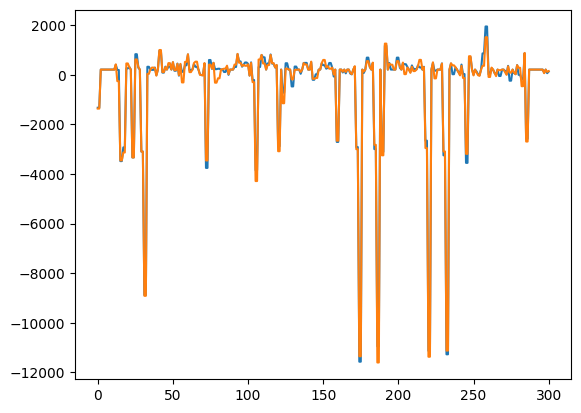

In [4]:
trace_directory = "ELMO/output/traces/"
outputfile      = 'ELMO/output/output.txt'
inputfile       = "ELMO/output/randdata.txt"

traces          = read_all_trace_files(trace_directory)
num_traces      = len(traces)

# plotting a few traces
plt.plot(traces[0])
plt.plot(traces[1])

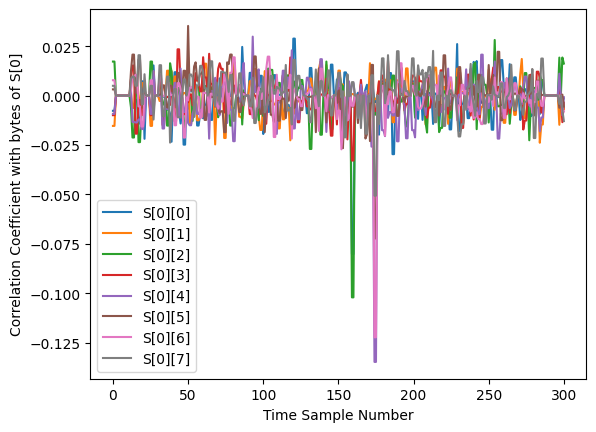

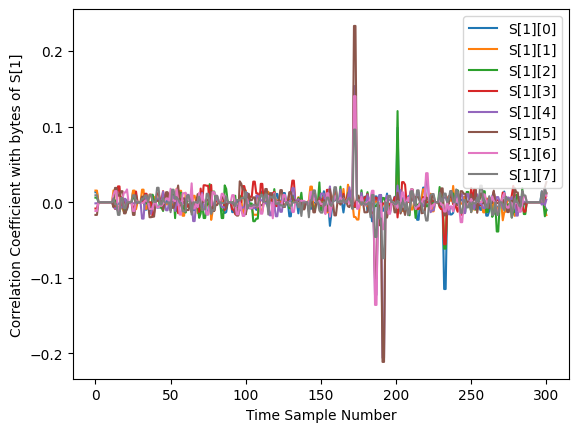

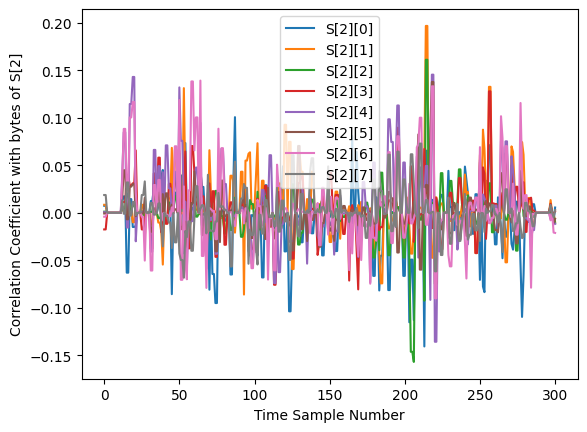

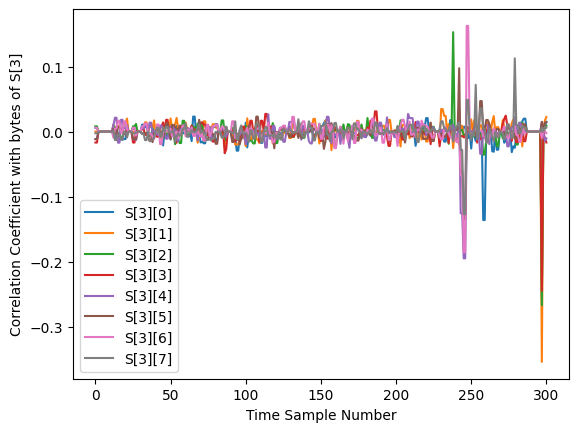

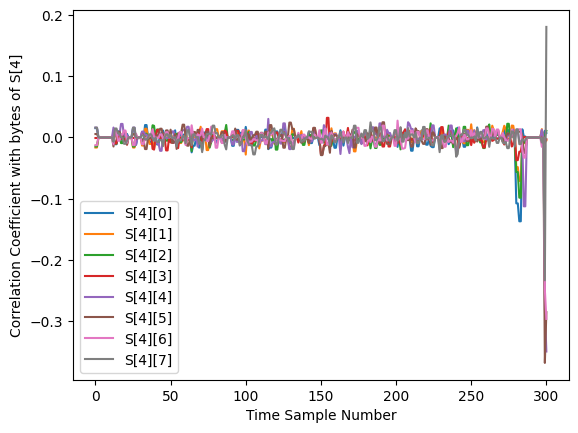

In [5]:
#############################################################
# Computing correlation coefficient directly from ELMO output
#############################################################

f     = open(outputfile, "r")
lines = f.readlines()

for word_position in range(NUM_ASCON_WORDS_IN_ASCON_STATE):
    plt.figure()
    for byte_position in range(NUM_BYTES_IN_ASCON_WORD):
        outputs = []
        count   = 0
        for line in lines:
            if (count % 5 == word_position):
                outputs.append(int((line[:-1].split(' ')[byte_position]), 16))
            count = count + 1

        plt.plot(evaluate_corr(np.array(traces[0:num_traces]),np.array(outputs[0:num_traces]).reshape(-1,1)))
    
    plt.xlabel("Time Sample Number")
    plt.ylabel("Correlation Coefficient with bytes of S[" + str(word_position) + "]")
    plt.legend(["S[" + str(word_position) + "][" + str(byte_position) + "]" for byte_position in range(NUM_BYTES_IN_ASCON_WORD)])

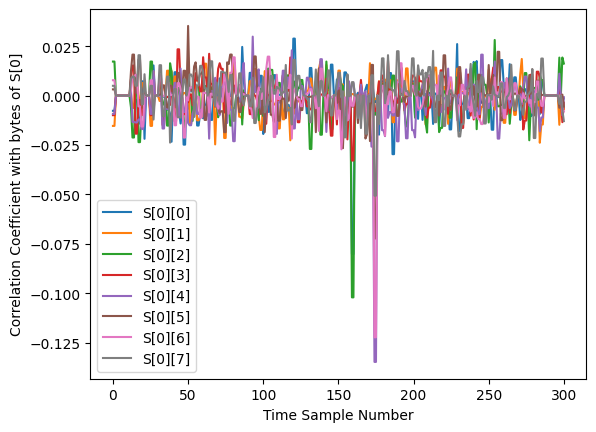

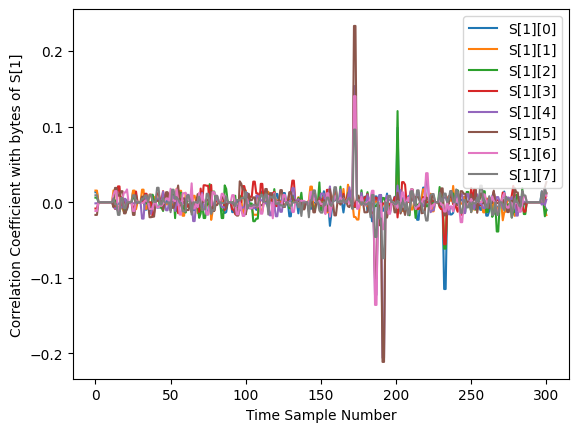

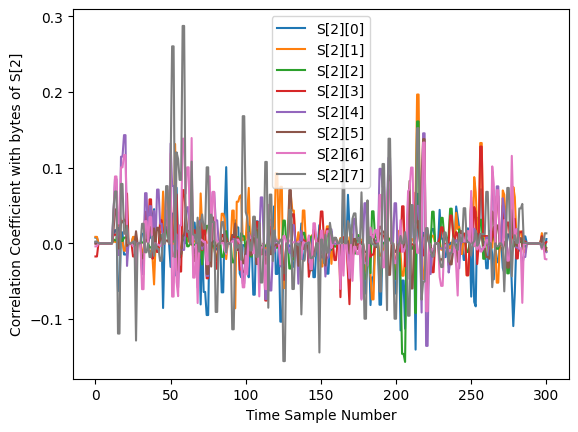

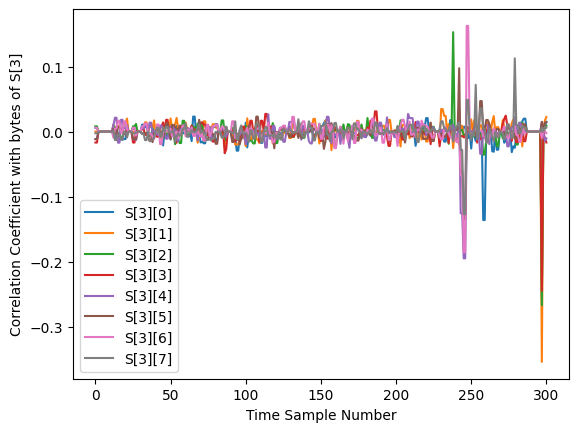

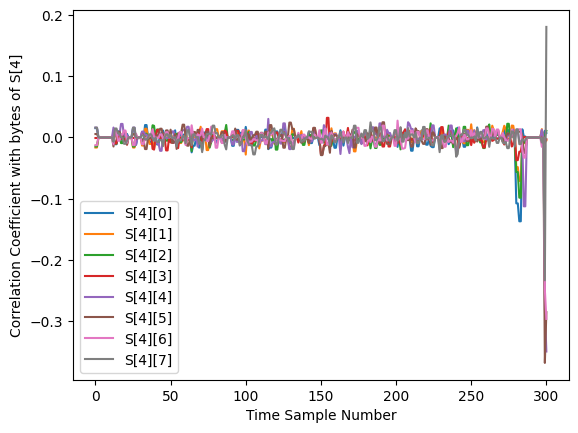

In [6]:
#############################################################
# Computing correlation coefficient from computed output
#############################################################

f        = open(inputfile, "r")
lines    = f.readlines()
line_num = 0

# first 16 lines contain the 128-bit key
k0       = [0] * NUM_BYTES_IN_ASCON_WORD
k1       = [0] * NUM_BYTES_IN_ASCON_WORD

for i in range(8):
    k0[i] = int(lines[line_num].strip('\n'), 16)
    line_num += 1
    k1[i] = int(lines[line_num].strip('\n'), 16)
    line_num += 1
    
K0 = load_bytes(k0, NUM_BYTES_IN_ASCON_WORD)
K1 = load_bytes(k1, NUM_BYTES_IN_ASCON_WORD)

for word_position in range(NUM_ASCON_WORDS_IN_ASCON_STATE):
    
    plt.figure()
    
    for byte_position in range(NUM_BYTES_IN_ASCON_WORD):
        
        outputs  = []
        line_num = 16
        
        for i in range(num_traces):
            
            n0 = [0] * NUM_BYTES_IN_ASCON_WORD
            n1 = [0] * NUM_BYTES_IN_ASCON_WORD

            for m in range(NUM_BYTES_IN_ASCON_WORD):
                n0[m] = int(lines[line_num].strip('\n'), 16)
                line_num += 1
                n1[m] = int(lines[line_num].strip('\n'), 16)
                line_num += 1

            N0 = load_bytes(n0, NUM_BYTES_IN_ASCON_WORD)
            N1 = load_bytes(n1, NUM_BYTES_IN_ASCON_WORD)

            S    = [0] * NUM_ASCON_WORDS_IN_ASCON_STATE
            S[0] = ASCON_128_IV + 0
            S[1] = K0           + 0
            S[2] = K1           + 0
            S[3] = N0           + 0
            S[4] = N1           + 0

            S, SBox_in, SBox_out = ascon_first_round(S, int('0xF0', 16))

            outputs.append((S[word_position] >> (byte_position * 8)) & 0xFF)

        plt.plot(evaluate_corr(np.array(traces[0:num_traces]),np.array(outputs[0:num_traces]).reshape(-1,1)))
    
    plt.xlabel("Time Sample Number")
    plt.ylabel("Correlation Coefficient with bytes of S[" + str(word_position) + "]")
    plt.legend(["S[" + str(word_position) + "][" + str(byte_position) + "]" for byte_position in range(NUM_BYTES_IN_ASCON_WORD)])